In [1]:
import numpy as np
import graphinglib as gl
from collections import namedtuple
import astropy.units as u

from src.hdu.cubes.cube_co import CubeCO
from src.spectrums.spectrum_co import SpectrumCO
from src.spectrums.spectrum import Spectrum
from src.hdu.tesseract import Tesseract
from src.hdu.maps.grouped_maps import GroupedMaps
from src.hdu.maps.convenient_funcs import get_FWHM
from src.coordinates.ds9_coords import DS9Coords

# Loop4N1

In [2]:
N1 = CubeCO.load("data/Loop4_co/N1/Loop4N1_FinalJS.fits")[500:800,:,:].bin((1,2,2))
N1.header["COMMENT"] = "Loop4N1_FinalJS was binned 2x2."
N1.header["COMMENT"] = "Loop4N1_FinalJS was sliced at channel 500; all values of mean must then be " \
                        + "added to 500 to account for this shift."
# N1.save("data/Loop4_co/N1/Loop4N1_FinalJS_bin2.fits")

## Fitting

In [3]:
if __name__ == "__main__":
    spectrum_parameters = {
        "PEAK_PROMINENCE" : 0.3,
        "PEAK_MINIMUM_DISTANCE" : 6,
        "PEAK_WIDTH" : 2,
        "INITIAL_GUESSES_BINNING" : 2,
        "MAX_RESIDUE_SIGMAS" : 5
    }

    chi2, fit_results = N1.fit(spectrum_parameters)
    chi2.save("data/Loop4_co/N1/chi2.fits")
    fit_results.save("data/Loop4_co/N1/tesseract.fits")

Number of processes used: 8


Fitting: 100%|██████████| 25/25 [00:02<00:00, 12.02fit/s]


## Slicing

In [ ]:
print(f"Targeted channel : {N1.header.get_frame(-4000, 0)}")
fit_results = Tesseract.load("data/Loop4_co/N1/tesseract.fits")

splits = ["lower_left", "lower_right", "upper"]
tesseract_splits = namedtuple("tesseract_splits", splits)
lower, upper = fit_results.split(14, 2)
lower_left, lower_right = lower.split(10, 3)
tesseract_splits = tesseract_splits(lower_left, lower_right, upper)

for split in splits:
    getattr(tesseract_splits, split).save(f"data/Loop4_co/N1/tesseract_splits/{split}.fits")

upper = tesseract_splits.upper.filter(slice(200, None))
lower_left = tesseract_splits.lower_left.filter(slice(197, None))
lower_right = tesseract_splits.lower_right.filter(slice(190, None))

lower = lower_left.concatenate(lower_right, 3)
total_object_N1 = lower.concatenate(upper, 2)

# Compressing the Tesseract
total_object_N1 = total_object_N1.compress()
total_object_N1.save(f"data/Loop4_co/N1/object.fits")

## Verifications

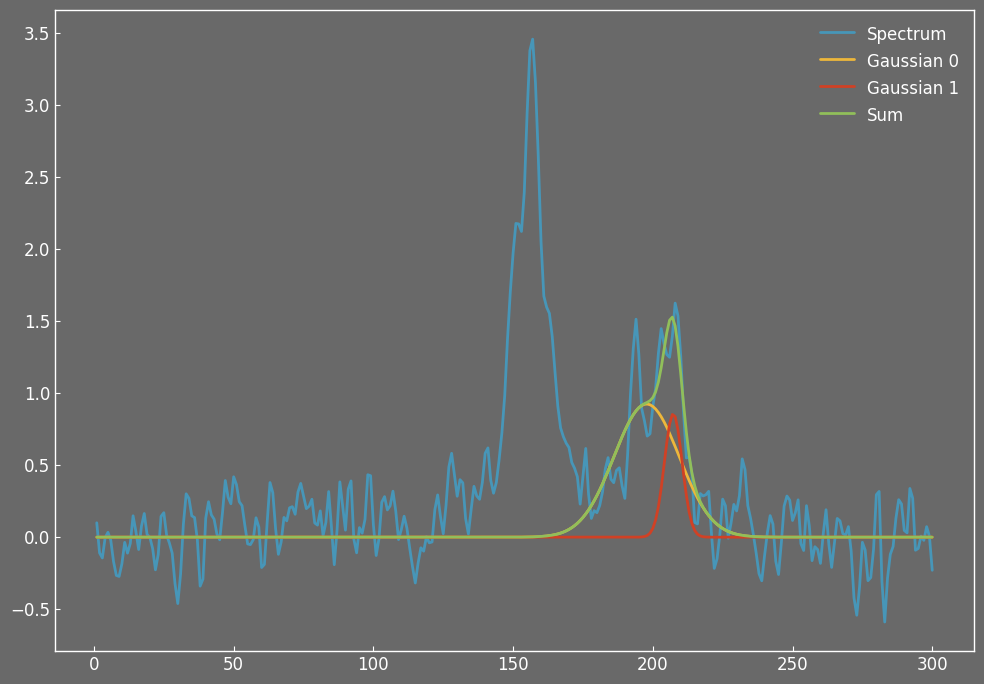

In [3]:
total_object_N1 = Tesseract.load(f"data/Loop4_co/N1/object.fits")
fig = gl.Figure(size=(10,7), figure_style="dim")
fig.add_elements(*total_object_N1.get_spectrum_plot(N1, DS9Coords(15, 8)))
fig.show()

## Refits

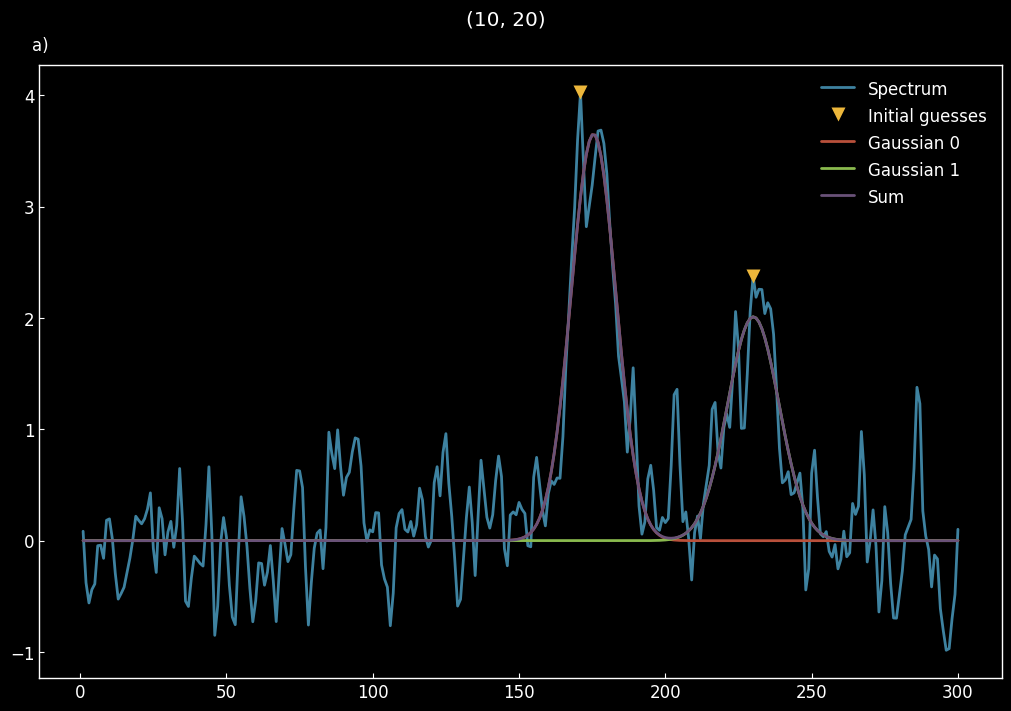

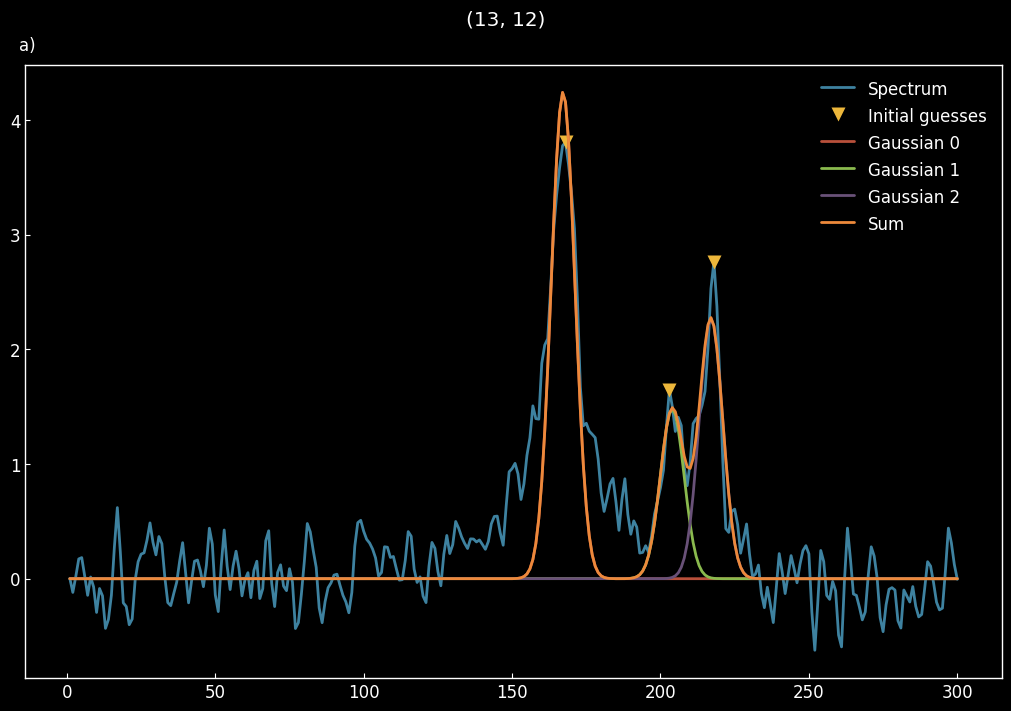

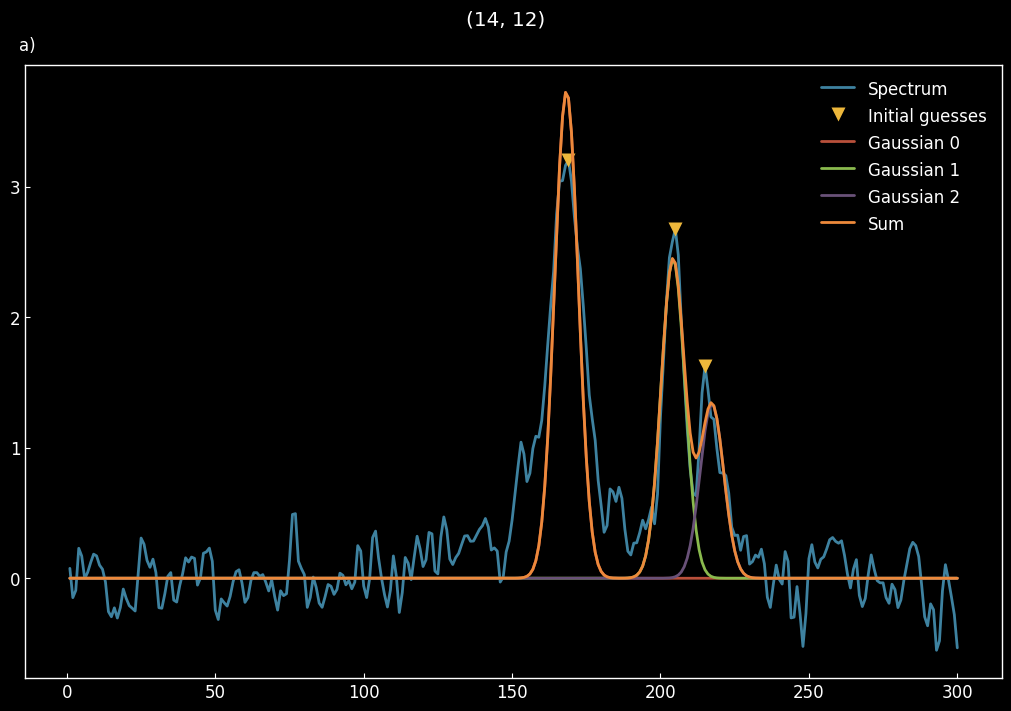

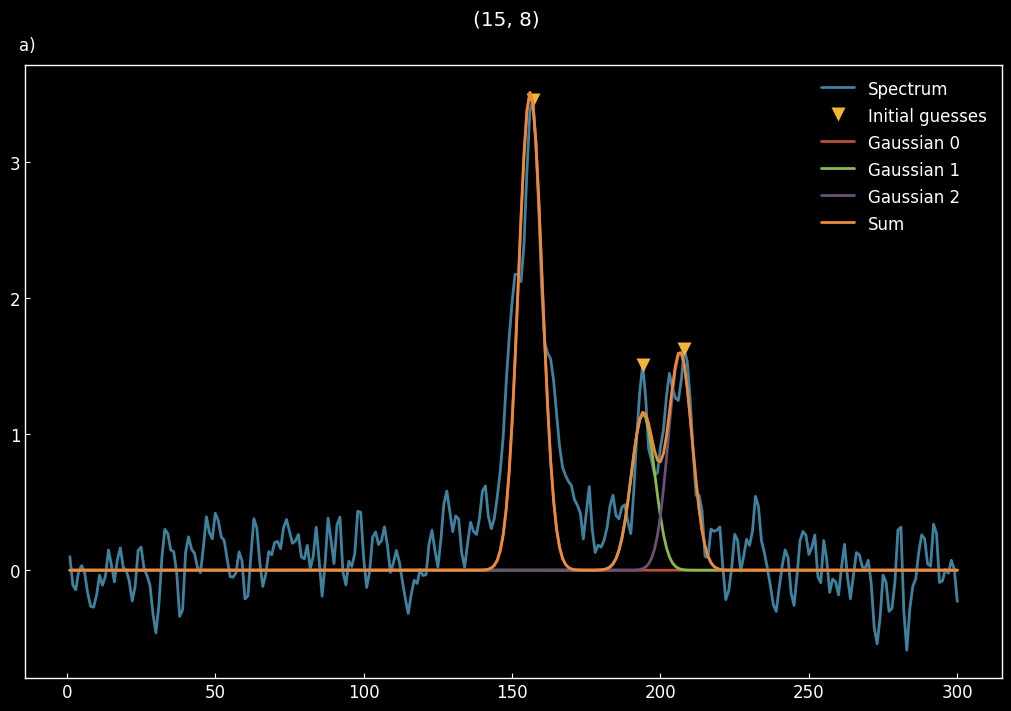

In [7]:
# Working in DS9Coods
spectrums = {
    (10, 20) : N1[:,*DS9Coords(10, 20)],
    (13, 12) : N1[:,*DS9Coords(13, 12)],
    (14, 12) : N1[:,*DS9Coords(14, 12)],
    (15, 8) : N1[:,*DS9Coords(15, 8)]
}

spectrums[(10, 20)].setattrs({"PEAK_MINIMUM_DISTANCE" : 20}); spectrums[(10, 20)].fit()
spectrums[(13, 12)].setattrs({}); spectrums[(13, 12)].fit({"stddev": (0, 4) * u.um})
spectrums[(14, 12)].setattrs({}); spectrums[(14, 12)].fit({"stddev": (0, 4) * u.um})
spectrums[(15, 8)].setattrs({}); spectrums[(15, 8)].fit({"stddev": (0, 4) * u.um})

for coords, spectrum in spectrums.items():
    multi_fig = gl.MultiFigure(1, 1, title=coords, figure_style="dark", size=(10, 7))
    fig = gl.Figure()
    fig.add_elements(spectrum.plot, spectrum.initial_guesses_plot, *spectrum.individual_functions_plot,
                     spectrum.total_functions_plot)
    multi_fig.add_figure(fig, 0, 0, 1, 1)
    multi_fig.show()
    total_object_N1[0,*DS9Coords(*coords)] = np.NAN
    total_object_N1[1,*DS9Coords(*coords)] = np.NAN
    for i, fit_result in enumerate(spectrum.fit_results.to_numpy()[1:]):
        # Loop on all the fit results, removing the first component
        total_object_N1[i,*DS9Coords(*coords)] = fit_result

total_object_N1.save("data/Loop4_co/N1/object_filtered.fits")


# Loop4N2

In [4]:
N2 = CubeCO.load("data/Loop4_co/N2/Loop4N2_Conv_Med_FinalJS_wcs.fits")[500:800,:,:]
N2.header["COMMENT"] = "Loop4N2_Conv_Med_FinalJS_wcs was sliced at channel 500; all values of mean must then be " \
                        + "added to 500 to account for this shift."

## Fitting

In [5]:
if __name__ == "__main__":
    spectrum_parameters = {
        "PEAK_PROMINENCE" : 0,
        "PEAK_MINIMUM_DISTANCE" : 6,
        "PEAK_WIDTH" : 2.5,
        "INITIAL_GUESSES_BINNING" : 2,
        "MAX_RESIDUE_SIGMAS" : 5
    }

    chi2, fit_results = N2.fit(spectrum_parameters)
    chi2.save("data/Loop4_co/N2/chi2.fits")
    fit_results.save("data/Loop4_co/N2/tesseract.fits")

Number of processes used: 8


Fitting: 100%|██████████| 30/30 [00:04<00:00,  6.88fit/s]


File overwritten.
File overwritten.


## Slicing

In [19]:
print(f"Targeted channel : {N2.header.get_frame(-3000, 0)}")
fit_results = Tesseract.load("data/Loop4_co/N2/tesseract.fits")

# total = fit_results.filter(slice(179, 240))


splits = ["left", "center", "right"]
tesseract_splits = namedtuple("tesseract_splits", splits)
left_center, right = fit_results.split(23, 3)       # right : >= 700
left, center = left_center.split(12, 3)             # left : >= 700, center : >= 684

tesseract_splits = tesseract_splits(left, center, right)

for split in splits:
    getattr(tesseract_splits, split).save(f"data/Loop4_co/N2/tesseract_splits/{split}.fits")

left = tesseract_splits.left.filter(slice(200, None))
center = tesseract_splits.center.filter(slice(184, None))
right = tesseract_splits.right.filter(slice(200, None))

left_center = left.concatenate(center, 3)
total = left_center.concatenate(right, 3)

# Compressing the Tesseract
total = total.compress()
total.save(f"data/Loop4_co/N2/object.fits")

Targeted channel : 209
File overwritten.
File overwritten.
File overwritten.
File overwritten.


## Verifications

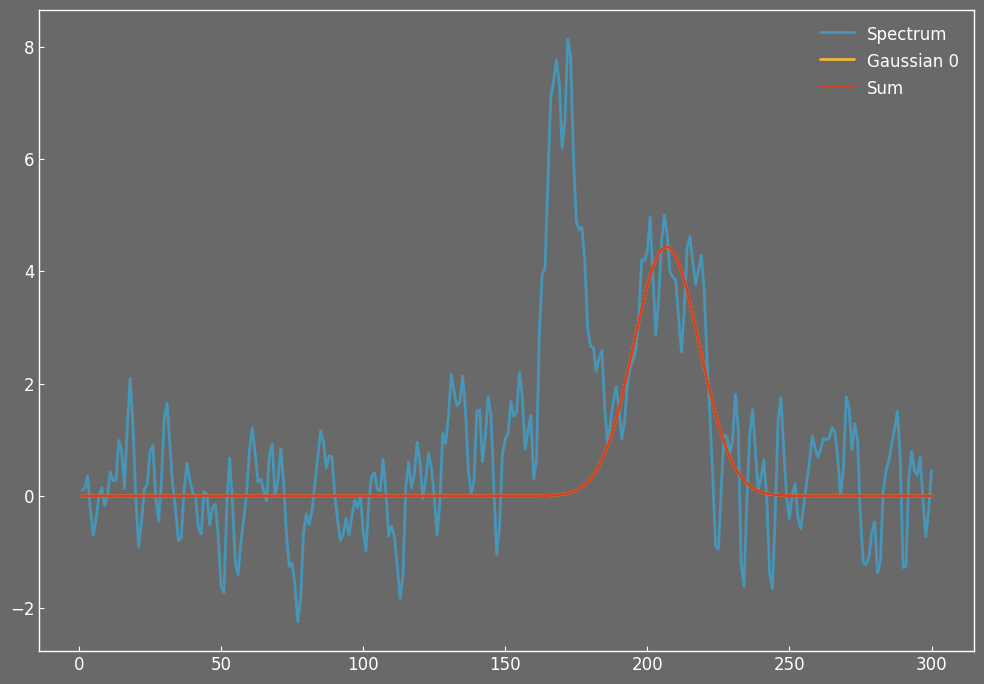

In [35]:
total_object_N2 = Tesseract.load(f"data/Loop4_co/N2/object.fits")
fig = gl.Figure(size=(10,7), figure_style="dim")
fig.add_elements(*total_object_N2.get_spectrum_plot(N2, DS9Coords(20, 15)))
fig.show()

## Refits

# Loop4N4

In [2]:
N4 = CubeCO.load("data/Loop4_co/N4/Loop4N4_Conv_Med_FinalJS_wcs.fits")[500:850,:,:]
N4.header["COMMENT"] = "Loop4N4_Conv_Med_FinalJS_wcs was sliced at channel 500; all values of mean must then be " \
                        + "added to 500 to account for this shift."

## Fitting

In [5]:
if __name__ == "__main__":
    spectrum_parameters = {
        "PEAK_PROMINENCE" : 0.3,
        "PEAK_MINIMUM_DISTANCE" : 6,
        "PEAK_WIDTH" : 2,
        "INITIAL_GUESSES_BINNING" : 2,
        "MAX_RESIDUE_SIGMAS" : 6
    }

    chi2, fit_results = N4.fit(spectrum_parameters)
    chi2.save("data/Loop4_co/N4/chi2.fits")
    fit_results.save("data/Loop4_co/N4/tesseract_2.fits")

Number of processes used: 8


Fitting:  10%|█         | 4/40 [00:00<00:01, 19.39fit/s]

1.3188787629017622 1.5834854525039885 < <1.54513228323332760.9229938679059329 2.626300617259602  1.298327618903515
 <2.729866664530421<  
0.9841950844757115<1.4030961759807554 1.3592657286827885  2.361674103861092.3587499785294743
<
<
  0.76107733499024771.19809564931667721.60015499591791072.1362506721997376  
<1.770278215406838
 <0.8942334271870731 0.9967077120946652 < <
2.9084808596461844 1.42156393698754682.540458266771313 
 1.434316057859503<
1.13990485668133431.3591241835044618 0.6443025033622461  
2.4269135997230786 <<0.6677849308739946<
   1.6305453742008982< 2.2898129689786641.6557967754481871.65174345959451680.8746998012045266
  
  0.82717973266174741.0338649376124205<
<<1.3836827278133026 
   1.4927834375565163.045261619041165<2.4164404837906464
 1.1244343154143697

1.2249930667688578  2.4787117113146135
<<  0.6086632243801361.92189021905324481.8017897296900351.4016254417077088
 1.0538808009635623
1.6430252512628045  1.035744854550011< 0.6322332255385947< <<    0.955502786535

Fitting:  15%|█▌        | 6/40 [00:02<00:16,  2.04fit/s]

      0.7012688804539159<1.3474676754840721.2242923335229057<<

   
1.01653731282032920.50586604667322841.1701769245899496


0.5174880016093228 < 0.5783796166563038
1.43176590282356160.316929578781023241.1591329583781147   <<<0.7741308808251477   0.73127825170765040.89563882719619431.2109618043620350.481582708573781051.9019095434502951.17189023240603560.5908791884391638     


<<<<<     1.26889125040300631.2109656884149171.01745723056778780.70682189231634611.5850518794568074




0.270555049180882250.593327403068272  <<0.6884931027881191   0.53165841529114221.00312907072025850.5490936340814663<0.7974147907988891 
  
<<1.1718902324060356  
0.66287973333623321.7293355655380354

1.07123386141386660.69767144812589890.28672607560377344   <<<  1.392096519470409 1.29856900534638830.89935365851756040.4315331159667005 


1.1358243046286993<0.6467415690413711   <<2.2393228231033580.9524765943886108 
  1.01745723056778781.2566798893264868<0.2448284626007228
 
0.6964125848370742 1.27294638945438581

Fitting:  20%|██        | 8/40 [00:03<00:15,  2.05fit/s]

0.757113397121318< 0.6706807099091341 1.5514527722442346  
0.83655691146882641.89321695081622730.6434584414580125<
<   0.8461301504878893< 1.2823416275175454 <<  1.1334697224206876
1.20868050124761721.54768257332351040.900079057503292 
0.9602524638167237 
0.8864256863476045 
<
<  1.79971683810376911.2745810453818327

1.1804438829409962 < 2.0882454208934336
1.82525295832793871.6396339357503598 < < 1.09432355248024220.5629860609762293  1.28202293439682011.104955389018641 

1.0890573263159886<<0.7807100361866248    1.2331992251589861.0272972262122555<< 

 1.47684443762644761.9512404952783382

1.0008963027380484 < 2.0345399108272404
1.008097659292305 1.15607783159691< < 0.54716074498889281.1338861757567158  1.76761718757415131.01635982533590851.87467385973207220.70767994068447680.7850036941303099 2.1100514685546647  < 
 < <<<<
    0.9165199863872313 
1.10495538906777211.26012068761057681.31069223680123931.28202293439682011.6881167977071.562792896205218


 

<0.9131070214399896  2.648345661

Fitting:  28%|██▊       | 11/40 [00:03<00:09,  2.98fit/s]

 
0.9467861668552697 < 1.51738564826553011.1936755919599573

0.8572155320279213 < 1.0806848157661335
1.5916904211026062 < 3.2120589215728215
1.0478015325018268 < 1.7664840741570185
1.0604636205251570.83795319488834560.8789016181202294   0.7885022367894707<0.9207597598309315<<0.9174644714300637     0.8166359066961068 0.6515672837277006<1.6043543700564644<0.914391371599606 1.1274882003111286 < 
<
 < 
 1.88605575585459741.51572487243503521.240908029492298 1.3829909032604402


1.684421765717044

1.034381322888559

Fitting:  32%|███▎      | 13/40 [00:03<00:07,  3.71fit/s]

 < 1.08116235373073471.4719661360476537 
<1.124240263375703  <1.9280556614971370.71080216942403741.0867543220517772
   1.6314236784324727<<1.1025818586346532 0.78400532743032990.907729386963017
 2.177538526645546 1.3234237643908204  <
<<0.9713998414887447
1.1135387483013004     <1.4438952676887422<1.13940455507237812.2930148830152177
  1.0288577663182652

1.07155441147024271.7871631936542975  1.7531332407910605
<
< 1.0763866666179343 1.53521005016660082.030564983246297 0.6576227167516226
0.9356147094613027
<   <0.87970104380743060.876829227472387< 1.5958044713180533 
 < 0.84557789251429830.8205232848325147 
 2.0879607652095413< <
1.1571720051708443 1.3378469330586849
2.3389950891727853

1.0494959626555354 <1.7588282940789595  1.04270062415669650.94889175891856380.6863148718485412< 1.879467705427997  0.93991822004329180.8288264059057708 <
 < <3.2234985900105757  < <
1.88312991483115691.15323632998494091.325734979928342  


1.46940999567106581.83443717037945041.0648988485336306

 <0.7636

Fitting:  35%|███▌      | 14/40 [00:05<00:11,  2.35fit/s]

 0.9642552747137656
1.00499188899971780.8629818808579421  <<  1.1716456714332261.8189482894938656

0.772692857480809 <1.2602791786196492  <0.83090039149979071.2184180676655023
 1.0141596081992180.9291525334117091 2.535493136681119< 1.4250587617732771.3686121530158002 0.7582929761131907 <<  
 <  0.8966313887217892<<1.680610991508676  2.0614957594161045 1.5959685247259445
 
2.10641721658076752.0682863743702864
1.1621381491838230.9232287704943402< 

 
<1.126385075826533
 1.25512337684522831.7593574858937713 0.91898868499049121.77306127064348231.5984539845425942<
1.3182725786925    < <<<  2.6349534680627817 1.3284112069172462
1.6997588218966542 2.47450903887581


2.1809504313668175
1.109175288776686 < 2.387933056351092
1.20973882088865460.760261553791705 < 1.0399241447441454  <<1.8201672239980102 
 1.974993726482710.8825132236367816

1.360202074049549 1.5016506516093981<1.3812174469917045   <0.97991770505905312.4796961244607334< 
1.139871832703549 1.4257708605050480.6765097100788596  2.478

Fitting:  42%|████▎     | 17/40 [00:05<00:07,  3.19fit/s]



 
1.0513450342471569
0.9603703707076363 1.3219424486157259<  0.99000561237235471.6726874037427304< 1.2579084722696212  <
1.5419914310800649<1.9114396275118395   1.23677709698671961.7174233476682794
<1.36377683800100961.3128861428493717   1.0213779768488527
 1.1038560942948261<
<<  
 1.34195974055400021.15756965490239061.63260942315394850.8782342159609934
1.8280629635614765
  <
< 1.5232262087184227 
1.618810049885011
1.11791663226146580.7704491424574156  <<0.7311504298596258   1.09265999141306611.25958430398176541.8854122007088231.213138873427921 < <<
 
1.328411206917247  1.13665483517636121.33659881417763040.8504751910277324


 < 1.48901928410492610.9531464576720645
1.26713400584201930.931082720112119   <1.6680741467411657<  <2.045306312969189 < 1.93494693625141641.35989105685446091.1038560942948261 
1.469878397414732 
1.1875727159080274 
<<
  2.7120903359347882.201789697232306

1.0484818309524773 <0.9624104201412054  1.13665483517636011.3705557127898516
<  <1.432492431614905
 1.2215

Fitting:  48%|████▊     | 19/40 [00:07<00:10,  2.02fit/s]




1.1776839670461852 1.5009746685133<1.8090948054602893 < 1.0853136010953341  <1.2916663584690644 

2.9018585735095925
0.913543352645782 < 1.0173937830980844
1.8333710616503178 < 1.4656200568734943.530875578570838
 < 1.7883846869249185
1.89185285568114870.9994206052611646  <<  4.381172982689971.0853136010959297

1.02182197069102 1.6697786301756292 <<1.4721704504768687 1.60559022426555133.203135310603731   <
<1.33894253960394181.072081312078756   
<3.6677109366221191.8588967297542371
0.6809161852333201
 1.6091166952627773
 < 1.2916663584690646
1.627897143362655 < 3.416360368319574
1.11065044608336551.05258926643075351.1176414040410294 2.077532466903637  <  << <1.2701860270417886 1.1692496908402292
 1.0989303046012748 1.52618541327076532.4714763545185017
<

 0.85545667192861432.488526469170626 <
0.961582998508609  0.8471796263805291.1741290543581677 
< <1.4809697625617546 1.4003605530003831.4184582449928318
1.5553884381298753 1.0934222635586126 
<<  < 2.03496412053221931.926480060200046

Fitting:  50%|█████     | 20/40 [00:09<00:16,  1.22fit/s]

1.1828355723566222 0.5477927450585183<0.8105173764225833 1.2258213338207540.6406887670718506   < 0.9190464535216633<<< 1.2413805850201463  
 < 1.10480252925788180.92421647982433631.22718837996196671.2003497417556164
1.326707626433221 
1.7899601226687583 

<
 2.2309821065136926
0.936080140151342 < 1.2979964706778178
0.8549758791923165 < 0.81455999612762990.67948474039821231.2518533934023572  1.217876917219547
 << < 1.2424570704547178 1.2425295262970293

1.76455000712822121.0137518449072103
 < 1.3565872758241353
1.0024859235355328 1.2950164824021633<  1.95643568038916231.18340034375808870.8999440255256590.95443924685984391.0883161472669525<0.99032303533963511.5920664982164325    
   <<<<1.5596908728831909<<    
  1.8163770716780941.22524965641482851.3040629990656271.7602382189083062.2923997133571811.303178077400216

1.4443928395692192



 < 0.94323976943818532.6074249577191431.095817296299769
 1.0066078901290174 < < < 1.712204434198314 1.17313625337251711.08663957559504
1.040475373820440

Fitting:  57%|█████▊    | 23/40 [00:10<00:10,  1.65fit/s]

<0.641173402059137
 0.8821962329036761 1.54011840251257870.9122963078651558<  
0.80637317019082120.8958348750103597<<   < <0.9567324097658885 1.3059929936018062
 1.2885979963122123 
1.2985884001932895
1.38572353293343280.7498918643912963

 0.8181924523951238<  <1.481966260816868 1.2393334241575740.96588088446913870.8877606987953237
 1.293238843256601  0.8152856413483008<
 <<<    1.79172357905178580.77649136582246551.83023719882154130.85719539663474560.74296578764845221.4285582887631123 

 
<
<  0.80657203707476681.4057695273259534 1.2963873022556394<

2.0271528799975305 1.140341706498634 
<0.7847545605840056  2.9296450655235535<1.0008934545275072
  0.5673457941576631.0152049789516395 < <
0.57389378462317180.9919678249093219  <1.1085975415616516
0.8307744860650066
 1.427686479903195  2.50859320243932030.8570950415851784 
<< < 1.4849991582696889 1.9365787727580577
1.6942236526830434
0.56862040969299950.6708513826249369
  <<  0.9255879779871644
1.1458240561663651.0366821932010015 
< 1.785

Fitting:  62%|██████▎   | 25/40 [00:11<00:07,  2.02fit/s]

<
0.9310517126148133  <1.19013807181231021.6942236537107176 
 0.94844188541543760.8244183339733790.77636408805845721.61121276234838<  
2.177605152130422  <<1.21401654273319571.442873953105774<   <  
1.035615056420498 1.01182722435205631.4564942010025788<

2.2416302188998341.6865789003611316 
0.97639626264573091.3396693310058858
  <
1.0170300375052728<   1.56644811694125070.7528962892691655<1.5411224248033388
1.0409810901093068
   1.1744243185563374<
< 0.90615322676418760.9975159022937451  0.9705150006784595 1.4266072952110114<<

1.2328626520562835 0.5715580994680911   0.86523027033986731.63914894388815041.6038012925737940.8071555566259013
< 
 < << 1.39443934374805271.93586057552346211.02527090566284460.9715394377685025   
1.0429771455225114
1.137326860118555< 0.79196733236236920.8584280944781095

<   

Fitting:  65%|██████▌   | 26/40 [00:11<00:06,  2.17fit/s]

<< 1.56644737076979720.7851851582516158 1.365830777036043  
<
1.76465772266030061.841351271589941.7391071708763006
 
 0.7641184068364125<1.4717782425633263  
<2.71202556505984840.8150239019848167  
1.021026269186762<1.01930557794326430.7897936575177651 
  < 1.3899974183258808<2.110954546339271
 1.09740712991599890.84351337040149881.1853934050553878
 0.5963785004140669
<  <1.2376318072936836< 0.8161329627042717   1.055979154428263 1.35503459252287681.3770486543651013<<0.9682857388894507
 
0.9106750902178821
   1.85347220905400321.429513819077901< 
<
1.3802780894685323  1.794133334120076<1.266199159244793
 
1.3087580075470190.8748910674075077
0.694570183753686  < 0.9813422700802328<0.96038811730898491.92385261488351241.3446593964012308    1.1748736824440853
1.1807465684261704<<< 
   < 1.71190002674013851.05597915442826331.6350027154814481.226279414480805



0.7163894435710714 0.90072953700967021.0792787474910925<   << 1.4092816775175914 1.93771742031470231.977813803041331


1.02179703746

Fitting:  68%|██████▊   | 27/40 [00:11<00:05,  2.25fit/s]

0.6100248768925672 1.070924273665825  < <<<    1.32137789152337451.19286074220102620.94138477310400241.71190002689966071.3802780959843531.1702948891377114


  
0.909198721330359<<  0.834160180289891  1.0797161022914021<1.308758007547019 
< 2.2996769952257234
0.9364416246162380.76262948514266461.05712790061533531.5104860325570313 
  <
< < 0.8369863809383503  1.39981789220045031.187815100038716
<
2.136138204357157
 0.9705772291300624
1.0682649612418966 0.6642897502165349< 1.01383369513738 < 2.29687084092943960.6528311309706183<1.1231379080625994 
   1.31515067338799540.8740253771503814<
1.614824780795316 <0.9834238805889178<  
  <1.07878024240999281.4554884132107735 
1.02729594707512551.2352696612765006
2.21185082392765 

0.8559183802496754<  <1.88791116805988631.2485306262962914
 0.7042826098650233 < 1.24802710602764180.7120504379261853<
1.584460827753189   0.9592341740777395 2.5909111319831821.1762571415817225
 <<
  <1.9303075366902111.0692663079338731.2269815919261216 0.90036925086883

Fitting:  70%|███████   | 28/40 [00:12<00:05,  2.22fit/s]

1.4508430934454979  << 0.8508398064905717 
2.13505334124569930.8309339250437882
 < 1.2324931948644535
0.735196948051316 < 1.5803287360964298
1.151796936988189 < 2.2692816174884570.6794646289765687
 1.855173282813991< 1.072418831932804 < 1.06009355137752251.168888718890526<  3.2451944073863137 0.82416129112244090.5816885801319069<
0.7166264355179404
   1.5325296656660585 2.119422099084922<
<<  
 0.95309568524923291.5309350182918471.0432962218221413


0.6429028716140874 1.3988027701076964<0.6349262366848915   <0.7647690409593917<
 0.6319712996478775  1.23954444610613872.7156220565274483<

 1.3003717328487634
1.0774643421170773 < 2.4238620167810945
1.0236252956688965 < 0.7942168998114059
0.7877774182289476 <1.0016401173914451.451960960318441   <1.190582399703341<  
2.3553840093921161.2060751235040454

1.0236253367790988 1.07746434211731 <1.6856332905223343 1.976599057738178< 0.8767648573745371   0.7942168998114059<<2.4238620167814475< 
 3.2949932773151467
 1.34673846790424311.288414924130

Fitting:  72%|███████▎  | 29/40 [00:14<00:09,  1.14fit/s]

1.4342173736275496
1.5239556966316283 < 1.8832317287292557
0.7089480501513706 < 1.2572912436700080.7249371278059896 
< 1.2809202215804412
1.246064901756017 < 2.09663591507753780.8423355640656122
 < 1.0624409903620893
1.0861357432569352 < 1.6042492977160645
1.3504186104670148 < 2.2219496060960746
1.7112603796263546 < 2.366489116019089
0.8781628912268246 < 1.3609696221844783
0.9165232067523186 < 1.4627164188472377
0.7135566558944324 < 1.1596145758704246
0.7361433636159643 < 0.8623529492834148
0.5971800269287928 < 0.8551668980092961
1.2152278423305374 < 1.4771615927890784


Fitting: 100%|██████████| 40/40 [00:15<00:00,  2.62fit/s]


File overwritten.


## Slicing

In [6]:
print(f"Targeted channel : {N4.header.get_frame(1000, 0)}")
fit_results = Tesseract.load("data/Loop4_co/N4/tesseract_2.fits")

total = fit_results.filter(slice(135, 195))

# Compressing the Tesseract
total = total.compress()
total.save(f"data/Loop4_co/N4/object_2.fits")

Targeted channel : 147
File overwritten.


## Verifications

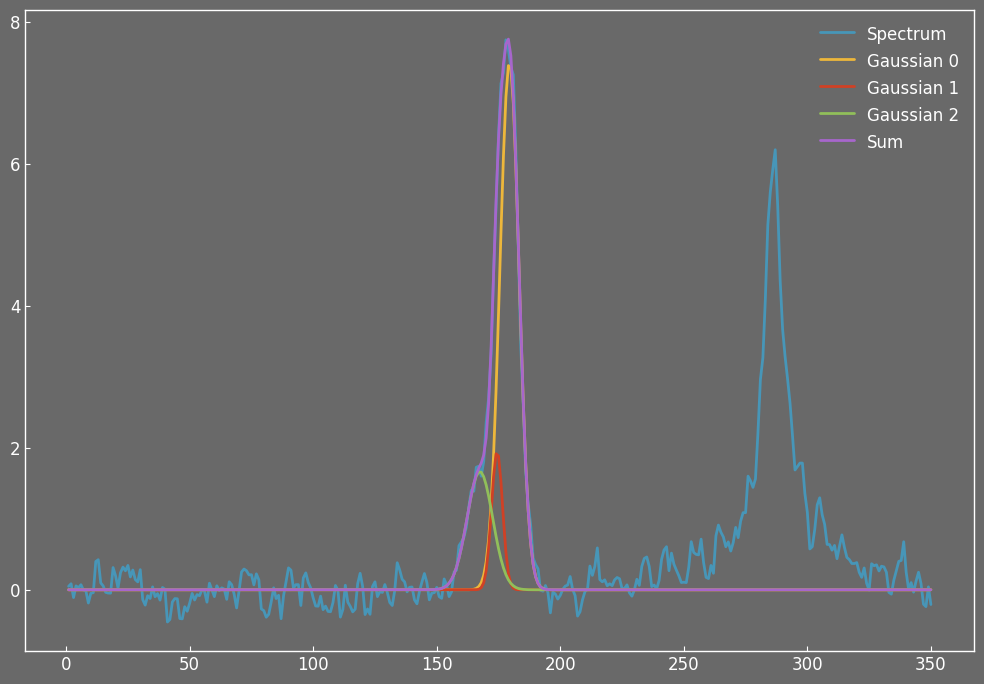

In [14]:
total_object_N4 = Tesseract.load(f"data/Loop4_co/N4/object_2.fits")
fig = gl.Figure(size=(10,7), figure_style="dim")
fig.add_elements(*total_object_N4.get_spectrum_plot(N4, DS9Coords(18, 8)))
fig.show()

## Refits

In [ ]:
# Working in DS9Coods
coords = [
    (35, 29), (35, 30), (19, 7), (18, 8), (22, 12), (33, 32)
]

spectrums = {coord : N4[:,*DS9Coords(*coord)] for coord in coords}



spectrums = {
    (21, 18) : N4[:,*DS9Coords(21, 18)],
    (36, 26) : N4[:,*DS9Coords(36, 26)],
    (35, 25) : N4[:,*DS9Coords(35, 25)],
    (36, 25) : N4[:,*DS9Coords(36, 25)],
}


# 36, 33
# 36, 32

spectrums[(10, 20)].setattrs({"PEAK_MINIMUM_DISTANCE" : 20}); spectrums[(10, 20)].fit()
spectrums[(13, 12)].setattrs({}); spectrums[(13, 12)].fit({"stddev": (0, 4) * u.um})
spectrums[(14, 12)].setattrs({}); spectrums[(14, 12)].fit({"stddev": (0, 4) * u.um})
spectrums[(15, 8)].setattrs({}); spectrums[(15, 8)].fit({"stddev": (0, 4) * u.um})

for coords, spectrum in spectrums.items():
    multi_fig = gl.MultiFigure(1, 1, title=coords, figure_style="dark", size=(10, 7))
    fig = gl.Figure()
    fig.add_elements(spectrum.plot, spectrum.initial_guesses_plot, *spectrum.individual_functions_plot,
                     spectrum.total_functions_plot)
    multi_fig.add_figure(fig, 0, 0, 1, 1)
    multi_fig.show()
    total_object_N4[0,*DS9Coords(*coords)] = np.NAN
    total_object_N4[1,*DS9Coords(*coords)] = np.NAN
    for i, fit_result in enumerate(spectrum.fit_results.to_numpy()[1:]):
        # Loop on all the fit results, removing the first component
        total_object_N4[i,*DS9Coords(*coords)] = fit_result

total_object_N4.save("data/Loop4_co/N4/object_filtered.fits")